# Pre-Processing and Training Data<a id='Pre-Processing_and_Training_Data'></a>

#  Contents<a id='Contents'></a>
* [1. Imports](#1._Imports)
* [2. Load The Data](#2._Load_Data)
* [3. Train/Test Split](#3._Train/Test_Split)
* [4. Scaling](#4._Scaling)
* [5. Logistic Model](#5._Logistic_Model)
    * [5.1 Train Test](#5.1_Train_test)
    * [5.2 Tuning](#5.2_Tuning)
    * [5.3 Pipeline](#5.3_Pipeline)
    * [5.4 Refining model using GridSearchCV](#5.4_Refine)
    
    

    



We will be using :
1. Logistic Regression
2. Random Forest
3. Gradient Boostind models
to predict whether or not a transaction is fraud

## 1. Imports <a id='1._Imports'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.pipeline import make_pipeline

## 2. Load The Data<a id='2._Load_Data'></a>

In [2]:
df = pd.read_csv('data/transaction_data_cleaned.csv')
print(df.shape)
df.head().T

(727282, 27)


,0,1,2,3,4
creditLimit,50000,20000,10000,2500,250
availableMoney,50000,20000,10000,2500,250
merchantName,Washington Post,cheapfast.com,discount.com,Fast Repair,staples.com
acqCountry,US,US,US,US,US
merchantCountryCode,US,US,US,US,US
posEntryMode,9,5,2,5,5
posConditionCode,1,1,8,1,1
merchantCategoryCode,subscriptions,online_retail,online_retail,auto,online_retail
transactionType,PURCHASE,PURCHASE,PURCHASE,ADDRESS_VERIFICATION,PURCHASE
cardPresent,False,False,False,False,False


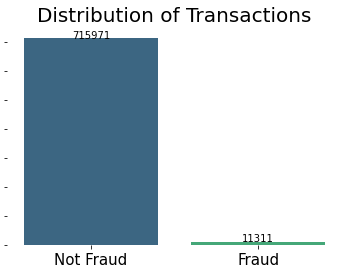

In [3]:
# using seaborns countplot to show distribution of fraud in dataset
fig, ax = plt.subplots()
g = sns.countplot(x=df.isFraud, palette='viridis')
g.set_xticklabels(['Not Fraud', 'Fraud'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

We have a very imbalanced data as we have noted during our cleaning process. We will need to change our scoring metric. That is, we should not use accuracy score since we will get a high accuracy score even if we just predict that all of our transactions are not fraud

## 3 Train/Test Split<a id='3._Train/Test_Split'></a>

#### Create dummy features for object type features

In [4]:
# Question 1: What do I do with merchant name ? There are many of them.
# 205 different values. should I change them too ?
df.merchantName.value_counts()

AMC                 35028
EZ Putt Putt        28497
Uber                23234
Lyft                23181
alibaba.com         15573
                    ...  
TMobile Wireless       47
Verizon Wireless       45
ATT                    44
Duane Reed             27
My Fitness              7
Name: merchantName, Length: 205, dtype: int64

In [5]:
df.dtypes

creditLimit                 float64
availableMoney              float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                  int64
posConditionCode              int64
merchantCategoryCode         object
transactionType              object
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
CVVMatch                       bool
containsCom                    bool
lengthOfLast4Digits           int64
creditLimitCategory           int64
transactionAmountBoxcox     float64
availableMoneyBoxcox        float64
currentBalanceBoxcox        float64
transactionTime               int64
transactionMonth              int64
dayOfTransaction              int64
expiryYear                    int64
expiryMonth                   int64
accountOpenYear               int64
accountOpenMonth              int64
yearOfLastAddressChange       int64
dtype: object

In [6]:
df.isnull().sum()

creditLimit                 0
availableMoney              0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
transactionType             0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
CVVMatch                    0
containsCom                 0
lengthOfLast4Digits         0
creditLimitCategory         0
transactionAmountBoxcox     0
availableMoneyBoxcox        0
currentBalanceBoxcox        0
transactionTime             0
transactionMonth            0
dayOfTransaction            0
expiryYear                  0
expiryMonth                 0
accountOpenYear             0
accountOpenMonth            0
yearOfLastAddressChange     0
dtype: int64

In [7]:
# Only take the first 50000 rows to test. delete this line later
df = df.sample(n = 50000) 


In [8]:
dummy_cols = ['acqCountry','merchantCategoryCode','merchantCountryCode','transactionType','merchantName']
df = pd.get_dummies(df, columns = dummy_cols)


In [9]:
# also convert merchantName to dummy variables
df

,creditLimit,availableMoney,posEntryMode,posConditionCode,cardPresent,expirationDateKeyInMatch,isFraud,CVVMatch,containsCom,lengthOfLast4Digits,...,merchantName_ikea.com,merchantName_netflix.com,merchantName_oldnavy.com,merchantName_pottery-barn.com,merchantName_sears.com,merchantName_staples.com,merchantName_target.com,merchantName_walmart.com,merchantName_westelm.com,merchantName_williamssonoma.com
230737,15000.0,11663.49,9,1,False,False,False,True,True,4,...,0,0,1,0,0,0,0,0,0,0
80799,10000.0,7726.21,2,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
174319,5000.0,5000.00,9,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
597237,15000.0,14266.06,2,1,False,False,False,True,True,4,...,0,0,0,0,0,0,0,0,0,0
9874,50000.0,45452.73,2,1,False,False,False,True,False,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720851,15000.0,11702.77,5,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
590574,7500.0,6812.38,5,1,False,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
409991,7500.0,2374.87,90,8,False,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
411983,5000.0,1241.48,9,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# X is everything but the target variable
# Is this ok ? variance threshold?
X = df.drop(columns = 'isFraud')
selector = VarianceThreshold(threshold=0.01)
selector.fit_transform(X)
y = df.isFraud

In [11]:
# use train test split method
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=47)

In [12]:
X_train.shape, X_test.shape

((35000, 255), (15000, 255))

## 4. Scaling<a id='4._Scaling'></a>




#### scale data to prepare for model creation

In [13]:
# #1. Call the StandardScaler`s fit method on `X_tr` to fit the scaler
scaler = StandardScaler().fit(X_train)

# 2.Transform the actual X_train and X_test data to be standard normal
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Question 2: Is it ok to have negative value?
X_train_scaled

array([[-2.85818861e-01,  4.52084936e-02,  3.68961015e-03, ...,
        -1.50975786e-01, -2.61951296e-02, -2.45022492e-02],
       [ 3.55917221e-01, -5.18154264e-01, -2.38819977e-01, ...,
        -1.50975786e-01, -2.61951296e-02, -2.45022492e-02],
       [-7.19068336e-02,  1.93061860e-01, -2.38819977e-01, ...,
        -1.50975786e-01, -2.61951296e-02,  4.08125798e+01],
       ...,
       [-8.41990133e-01, -6.40187141e-01, -2.38819977e-01, ...,
        -1.50975786e-01, -2.61951296e-02, -2.45022492e-02],
       [-7.19068336e-02,  1.96959057e-01, -4.20702168e-01, ...,
        -1.50975786e-01, -2.61951296e-02, -2.45022492e-02],
       [-7.19068336e-02, -6.71320282e-02, -2.38819977e-01, ...,
        -1.50975786e-01, -2.61951296e-02, -2.45022492e-02]])

## 5. Logisitic Model<a id='5._Logistic_Model'></a>


### 5.1 Train test<a id='5.1_Train_test'></a>

    
    

In [15]:
clf = LogisticRegression()

In [16]:
clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [17]:
# Question 3 is it normal to have f_score 0?
# check score on the test data
print("accuracy: ",accuracy_score(y_test, clf.predict(X_test_scaled)))
print("f1 score: ",f1_score(y_test, clf.predict(X_test_scaled)))

accuracy:  0.9861333333333333
f1 score:  0.0


In [18]:
#  confusion matrix 
pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_scaled)))

,0,1
0,14792,0
1,208,0


We have a very good accuracy even without setting the parameter. This is because of the imbalance data. 
We are predicting that everything is not fraud.

### 5.2 Tune the Model<a id='5.2_Tuning'></a>

Lets tune the model to take into account the imbalanceness and see if we can get higher f1_score. In Logistic Regression, the most important parameter to tune is the regularization parameter C. Note that the regularization parameter is not always part of the logistic regression model.



We use the following cv_score function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from numpy import mean

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# create model
clf = LogisticRegression()


For each C:
1. Create a logistic regression model with that value of C
2. Find the average score for this model using the cross_val_score function **only on the training set** (X_train_scaled, y_train)

In [21]:
# A. cross_val_score
# the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
max_score = 0
for C in Cs:
        # 1.we pass in C as the argument for regularization parameter C
        clf = LogisticRegression(C = C)
        
        # 2. take the score of the model above
        score = mean(cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=cv, n_jobs=-1))

        # 3. get best score
        if score > max_score:
            max_score = score
            best_C = C
print(max_score, best_C)


0.985057142857143 0.001


### 5.3 Pipeline<a id='5.3_Pipeline'></a>

#### 5.3.1 Define the pipeline

In [22]:
from sklearn.feature_selection import SelectKBest, f_regression

pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression), 
    # should I not input best_C for argument in Logistic Reg() because gridsearchCV will decide?
    LogisticRegression())

#### 5.3.2 Fit the pipeline

In [23]:
# ignore warning true_divide
# but why is it dividing by zero ?
# np.seterr(divide='ignore', invalid='ignore')

pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f921d9158b0>)),
                ('logisticregression', LogisticRegression())])

In [24]:
# check list of estimator for gridCV
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

### 5.4 Refine Model using GridSearchCV<a id='5.4_Refine'></a>

##### 5.4.1 Create grid

In [25]:
# Question 4: invalid value encountered in true divide in terminal while executing this
# How to remove it?
# 1. RuntimeWarning: invalid value encountered in true_divide
#   corr /= X_norms in terminal
# 2. it never finishes

k = [k+1 for k in range(len(X_train.columns))]
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [0.001, 0.1, 1, 10, 100]

grid = dict(selectkbest__k = k,
            logisticregression__solver = solvers,
            logisticregression__penalty = penalty,
            logisticregression__C = c_values)

grid_search = GridSearchCV(pipe, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

##### 5.4.2 Summarize Results

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

##### 5.4.3 Check best params

In [ ]:
# See if best C is the same as before gridCvSearch
grid_search.best_params_


##### 5.4.4 Predict and get final scores of the best param

In [ ]:
# create clf again using our best param from gridCV
clf = LogisticRegression(C = 100, penalty = 'l2', solver = 'newton-cg', max_iter = 2000)

# fit the model using train data
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test_scaled)

# calculate accuracy
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred)

In [ ]:
# do we need that ? we have to compare ROC AUC ?
# After ROC/AUC then Im ready to do the next model ?